# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

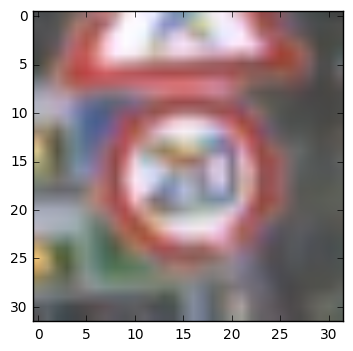

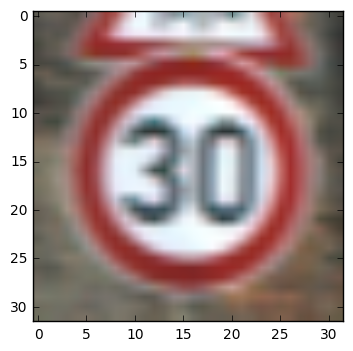

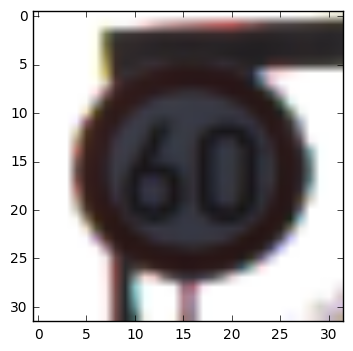

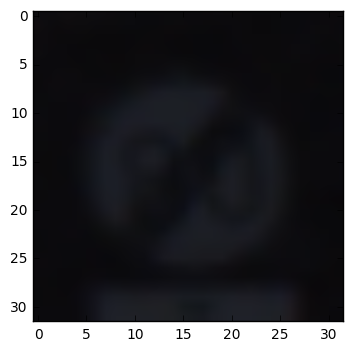

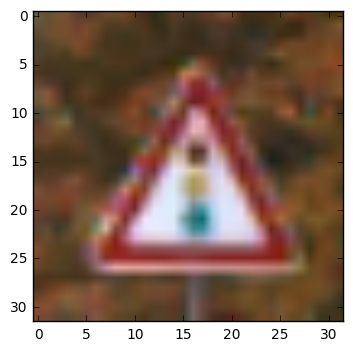

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

# Check Random Five Images
plt.imshow(np.array(X_train[0]))
plt.show()
plt.imshow(np.array(X_train[1000]))
plt.show()
plt.imshow(np.array(X_train[5000]))
plt.show()
plt.imshow(np.array(X_train[10000]))
plt.show()
plt.imshow(np.array(X_train[30000]))
plt.show()

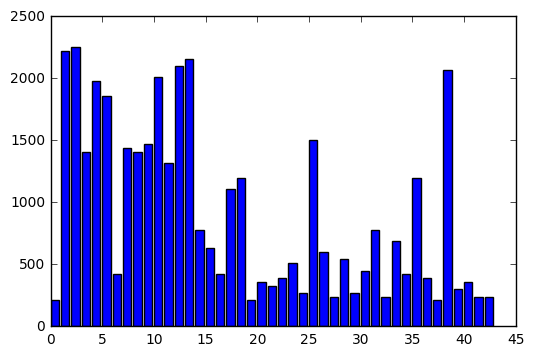

Data Distribution!


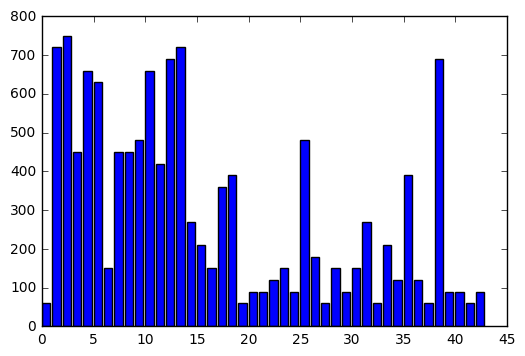

Data Distribution!


In [5]:
#Function to Check Distribution of Training Data
def display_data_distribution(input_labels):
    img_count_per_class = np.bincount(input_labels)
    class_values_list = np.unique(input_labels)
    fig = plt.figure()
    ax = plt.subplot(111)
    ax.bar(class_values_list, img_count_per_class)
    plt.show()
    print ("Data Distribution!")

display_data_distribution(y_train)
display_data_distribution(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [13]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
import scipy.ndimage
import math
from sklearn.utils import shuffle
import cv2


def convert_to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def change_brightness(image):
    random_bright = .25+np.random.uniform()
    image = image * random_bright
    return image


def transform_image(img, angles_range, shear_range, trans_range):
    # Rotation
    angle_rotation = np.random.uniform(angles_range) - angles_range/2
    rows, cols = img.shape    
    rotation_matrix = cv2.getRotationMatrix2D((cols/2,rows/2), angle_rotation, 1)

    # Translation
    trans_x = trans_range * np.random.uniform() - trans_range/2
    trans_y = trans_range * np.random.uniform() - trans_range/2
    trans_matrix = np.float32([[1, 0, trans_x], [0, 1, trans_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
    pt1 = 5 + shear_range * np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range/2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_matrix = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img, rotation_matrix, (cols,rows))
    img = cv2.warpAffine(img, trans_matrix, (cols,rows))
    img = cv2.warpAffine(img, shear_matrix, (cols,rows))
    
    return img


def normalize_images(images):
    images = np.array(images)
    images = images - 128. / 128.
    return images


def random_shuffle(images, labels):
    features_train, labels_train = shuffle(images, labels)
    return features_train, labels_train


images_train_grayscaled, images_test_grayscaled = [], []
for each_img in X_train:
    images_train_grayscaled.append(convert_to_grayscale(each_img))

for each_img in X_test:
    images_test_grayscaled.append(convert_to_grayscale(each_img))

features_train = np.array(images_train_grayscaled)
features_test = np.array(images_test_grayscaled)
labels_train = np.array(y_train)
labels_test = np.array(y_test)


print("Given Training Data - {}".format(len(features_train)))

print("Preprocessing Data")
features_train = normalize_images(features_train)
features_test = normalize_images(features_test)

features_train, labels_train = random_shuffle(features_train, labels_train)

print("Images Randomly shuffled and Normalized!")

Given Training Data - 39209
Preprocessing Data
Images Randomly shuffled and Normalized!


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

**1)** The images dimensions were changed from (32, 32, 3) to (32, 32, 1) as grayscale image gave better result on test data.

**2)** Pixel values were normalized between [-1, 1] so as to ensure fast convergence for the optimizer. If the range of values are broad, then the optimizer will jump around a lot and the convergence will be slow.

Number of Training Images - 29159, Training Labels - 29159
Number of Validation Images - 9720, Validation Labels - 9720
Number of Test Images - 12960, Test Labels - 12960


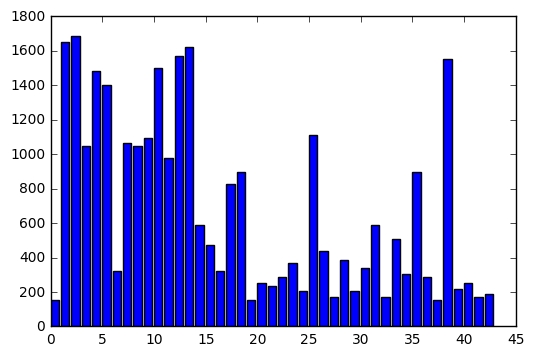

Data Distribution!


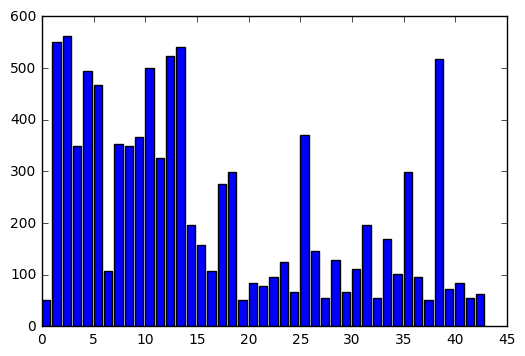

Data Distribution!


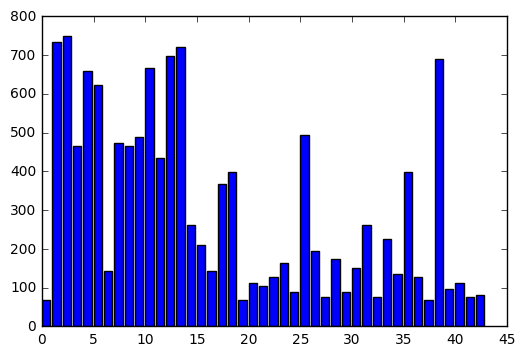

Data Distribution!


In [14]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
from sklearn.model_selection import train_test_split


images_all = np.concatenate((features_train, features_test), axis = 0)
labels_all = np.concatenate((labels_train, labels_test), axis = 0)
features_train, features_test, labels_train, labels_test = train_test_split(images_all, labels_all, 
                                                            test_size=0.25, stratify = labels_all )
features_train, features_valid, labels_train, labels_valid = train_test_split(features_train, labels_train, 
                                                            test_size=0.25, stratify = labels_train )

print ("Number of Training Images - {}, Training Labels - {}".format(len(features_train), len(labels_train)))
print ("Number of Validation Images - {}, Validation Labels - {}".format(len(features_valid), len(labels_valid)))
print ("Number of Test Images - {}, Test Labels - {}".format(len(features_test), len(labels_test)))

display_data_distribution(labels_train)
display_data_distribution(labels_valid)
display_data_distribution(labels_test)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

***Technique 1***

**1)** I split the training set into 70% data for training and 30% for validation. Test data was not touched, apart from converting them from colored to grayscale.

**2)** Additional data was generated during batch processing step in CNN. I used affine transformation to generate additional data. Images were randomly rotated by maximum of 40 degrees and translate them by maximum of 5 units while maintaining parallelism between the lines. 5 additional augmented images were generated for each image.

**Test Accuracy - 92.7%**


***Technique 2***

My mentor advised me that one of the reasons why test accuracy is not increasing is because of the fact that test images may be quite different than training images. Let's assume there are 100 images of a class. 80 images are in train.p file and rest 20 in test.p file. So, it is better to randomly shuffle these 100 images rather than use the sequential data given to us. The main idea of a generalized model is that test data is touched only when one is confident about the model. So, in short **hide the test data**.

**1)** I mixed training and test data together and randomly shuffled them.

**2)** Then, 75% data drawn from this mixture was used for training and rest 25% data was set aside as test set.

**3)** 75% training data from previous step was again divided into two sets of (75%, 25%). 25% data from this step was used as validation set and the other 75% data was used for training purposes.

**4)** So, despite mixing original training and test data, we derived separate training, validation and test sets.

**5)** Additional images are generated in batch processing step in CNN. I used affine transformation to generate additional data. Original images were randomly rotated by maximum of 40 degrees and translated them by maximum of 5 units while maintaining parallelism between the lines. 5 additional augmented images were generated for each image which were fed into the training set during batch processing. It is important to make sure that every batch has augmented data uniformly. This helps the model to learn better.

**Test Accuracy - 98.48%**


In [15]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

learning_rate = 0.001
batch_size = 64
training_epochs = 75
n_classes = 43

layer_width = {
    'layer_1': 32,
    'layer_2': 64,
    'layer_3': 128,
    'fully_connected1': 512,
    'fully_connected2': 512
}

weights = {
    'layer_1': tf.Variable(tf.truncated_normal([5, 5, 1, layer_width['layer_1']], mean=0, stddev=0.01), name="model1_wl1"),
    'layer_2': tf.Variable(tf.truncated_normal([5, 5, layer_width['layer_1'], layer_width['layer_2']],mean=0, stddev=0.01), name="model1_wl2"),
    'layer_3': tf.Variable(tf.truncated_normal([5, 5, layer_width['layer_2'], layer_width['layer_3']],mean=0, stddev=0.01), name="model1_wl3"),
    'fully_connected1': tf.Variable(tf.truncated_normal([4*4*128, layer_width['fully_connected1']],mean=0, stddev=0.01), name="model1_fc11"),
    'fully_connected2': tf.Variable(tf.truncated_normal([layer_width['fully_connected1'], layer_width['fully_connected2']],mean=0, stddev=0.01), name="model1_fc12"),
    'out': tf.Variable(tf.truncated_normal([layer_width['fully_connected2'], n_classes],mean=0, stddev=0.01), name="model1_out")
}
biases = {
    'layer_1': tf.Variable(tf.zeros(layer_width['layer_1']), name="model1_b1"),
    'layer_2': tf.Variable(tf.zeros(layer_width['layer_2']), name="model1_b2"),
    'layer_3': tf.Variable(tf.zeros(layer_width['layer_3']), name="model1_b3"),
    'fully_connected1': tf.Variable(tf.zeros(layer_width['fully_connected1']), name="model1_bfc1"),
    'fully_connected2': tf.Variable(tf.zeros(layer_width['fully_connected2']), name="model1_bfc2"),
    'out': tf.Variable(tf.zeros(n_classes), name="model1_bout1")
}


def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')

def conv_net(x, weights, biases, dropout):
    conv1 = conv2d(x, weights['layer_1'], biases['layer_1'])
    conv1 = maxpool2d(conv1)

    conv2 = conv2d(conv1, weights['layer_2'], biases['layer_2'])
    conv2 = maxpool2d(conv2)

    conv3 = conv2d(conv2, weights['layer_3'], biases['layer_3'])
    conv3 = maxpool2d(conv3)
    
    fc1 = tf.reshape(conv3, [-1, weights['fully_connected1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['fully_connected1']), biases['fully_connected1'])
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    fc2 = tf.add(tf.matmul(fc1, weights['fully_connected2']), biases['fully_connected2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, dropout)
    
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out


def convert_to_one_hot(labels_dense, num_classes=43):
  num_labels = labels_dense.shape[0]
  index_offset = np.arange(num_labels) * num_classes
  labels_one_hot = np.zeros((num_labels, num_classes))
  labels_one_hot.flat[index_offset + labels_dense.ravel()] = 1
  return labels_one_hot

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

***FINAL MODEL***

**1) Convolutional Layers (Count - 3)**

   i) **Layer 1** has 5X5 filters with stride of 1 and depth of 32. Max-pooling is present after this layer.
    
   ii) **Layer 2** has 5X5 filters with stride of 1 and depth of 64. Max-pooling is present after this layer. 
   
   iii) **Layer 3** has 5X5 filters with stride of 1 and depth of 128. Max-pooling is present after this layer.   
   
      
        1. (32, 32, 1) -> (16, 16, 32)
       
        2. (16, 16, 32) -> (8, 8, 64)
         
        3. (8, 8, 64) -> (4, 4, 128)
        
        

**2) Fully Connected Layers (Count - 2)**
    
   i) Output from Layer 3 of convolutional neural network is fed to the fully connected layer 1 (FC1) i.e., 4 X 4 X    128 = 2048 neurons are flattened and fed to the fully connected layer 1. Then, the output from FC1 is passed through a ReLU and a Dropout Layer.
    
   ii) The Output from Dropout layer of previous step is fed to Fully Connected Layer 2 (FC2). Then, there are ReLU and Dropout layers after FC2.
    
   iii) Result from the dropout layer after FC2 is then sent to the output layer to get the LOGITS.

**3) Convolutional and Maxpool Layers use 'SAME' padding.**

**4) Labels for training, validation and testing data have been One Hot Encoded.**

In [16]:
### Train your model here.
### Feel free to use as many code cells as needed.
# tf Graph input
import time
import os

saver = tf.train.Saver()
save_dir = 'checkpoints_final_res/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = os.path.join(save_dir, 'validation')

x = tf.placeholder("float", [None, 32, 32, 1])
y = tf.placeholder("float", [None, n_classes])

logits = conv_net(x, weights, biases, dropout=0.5)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

best_res = 0

additional_image = 5

init = tf.global_variables_initializer()

sess = tf.Session()
sess.run(init)
num_examples = len(features_train)

for epoch in range(training_epochs):
    start = time.time()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = features_train[offset:offset+batch_size], labels_train[offset:offset+batch_size]
        ###Augment Data for each image i.e, create 5 new images for each image
        for index, each_img in enumerate(batch_x):
            class_val = batch_y[index]
            for ind in range(additional_image):
                new_image = np.expand_dims(transform_image(change_brightness(each_img), 40, 10, 5), axis=0)
                batch_x = np.concatenate((batch_x, new_image))
                batch_y = np.append(batch_y, class_val) 
        batch_x, batch_y = random_shuffle(batch_x, batch_y)
        batch_x = np.expand_dims(batch_x, axis=3)
        batch_y = convert_to_one_hot(batch_y)
        
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y})
        
    c = sess.run(cost, feed_dict={x: batch_x, y: batch_y})
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, np.float32))
    a = accuracy.eval({x: batch_x, y: batch_y}, session=sess)
    print("\n\nEpoch - {}".format(epoch + 1))
    print("Cost - ", "{:.8f}".format(c))
    print("Accuracy on last batch - ", "{:.8f}".format(a))

    end = time.time()
    hours, rem = divmod(end - start, 3600)
    minutes, seconds = divmod(rem, 60)

    print("Optimization Time - ", "{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

    accuracy = tf.reduce_mean(tf.cast(correct_prediction, np.float32))
    
    validation_acc = accuracy.eval({x: np.expand_dims(features_valid, axis=3), 
                                    y: convert_to_one_hot(labels_valid)}, session=sess)
    
    if validation_acc > best_res:
        best_res = validation_acc
        saver.save(sess=sess, save_path=save_path)
        print("Best Model saved")

    print("Accuracy on Validation data - ", "{:.8f}".format(validation_acc))

print("Optimization Finished!")



Epoch - 1
Cost -  1.96673787
Accuracy on last batch -  0.35042736
Optimization Time -  00:01:48.52
Best Model saved
Accuracy on Validation data -  0.45051438


Epoch - 2
Cost -  0.63895905
Accuracy on last batch -  0.78205132
Optimization Time -  00:01:48.75
Best Model saved
Accuracy on Validation data -  0.86892998


Epoch - 3
Cost -  0.59759849
Accuracy on last batch -  0.83760697
Optimization Time -  00:01:47.58
Best Model saved
Accuracy on Validation data -  0.92170775


Epoch - 4
Cost -  0.31650698
Accuracy on last batch -  0.89743596
Optimization Time -  00:01:47.31
Best Model saved
Accuracy on Validation data -  0.95781881


Epoch - 5
Cost -  0.21141908
Accuracy on last batch -  0.94017094
Optimization Time -  00:01:49.02
Best Model saved
Accuracy on Validation data -  0.96460897


Epoch - 6
Cost -  0.21874085
Accuracy on last batch -  0.91452998
Optimization Time -  00:01:45.44
Best Model saved
Accuracy on Validation data -  0.97139907


Epoch - 7
Cost -  0.13837348
Accuracy 

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

1) I used AdamOptimizer with a learning rate of 0.001. AdmaOptimizer performed better than GradientDescentOptimizer.

2) Batch Size used is 384. In the code, we may see that batch_size = 64 but for each image in this batch I am generating 5 extra augmented images while passing them to the optimization step. So, 64 + 5 X 64 = 384 is the actual batch size.

3) Epoch Size of 75. Beyond this, model was not increasing it's accuracy by much on validation data and test data.

4) Dropout = 0.5 for the fully connected layers. Conv Layers don't have dropout.

5) I used trail and error to come up with these values.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

The model used here was result of trial and error. 

1) I tried a 2 layer conv net with depths of (128, 256) and FC layer of depth (1024). Accuracy was much lower. 

2) Also, a 3 layer CNN gave accuracy of 89% on test data without using extra augmented images and maintaining the color channels.. 

3) Converting colored images to grayscale improved accuracy by around 1.5% on 3 layer CNN.

4) While reading carnd forum I came to know that augmented data helps generalize the model much more and helps in improving the accuracy. So, I chose to stick with the architecture and tune the hyper-parameters.

5) Also, keeping in mind the advice given by my mentor, I mixed Training and Test data together and then randomly shuffled them. The shuffled data was divided into training, validation and test data set.

6) The model which gave the best validation results over the course of epochs was saved and used to get the results on test data.

7) The model used here gave accuracy of 98.48% when additional augmented images were used in batch processing. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [17]:
saver.restore(sess=sess, save_path=save_path)
acc = accuracy.eval({x: np.expand_dims(features_test, axis=3), y: convert_to_one_hot(labels_test)}, session=sess)
print("Accuracy on Test data by Best Validation Accuracy Model - ", "{:.8f}".format(acc))

Accuracy on Test data by Best Validation Accuracy Model -  0.99074113


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

1) 5 random traffic signs were downloaded from Google.

2) Some of the images had 4 color channels so, instead of converting images with 4 color channels to grayscale I chose to search images with 3 color channels and then convert them to grayscale for testing.

3) I guess, despite the fact that CNN takes care of spatial translation of features, the model is heavily biased towards traffic signs which are present in the centre of the images because the training data is as such. The traffic sign which was wrongly classified was tilted in opposite direction to the training data for the same image class.

['wild_animal.jpg', 'narrow_right.jpg', 'stop.jpeg', 'speed_limit_50.jpg', 'dangerous_left.jpeg']


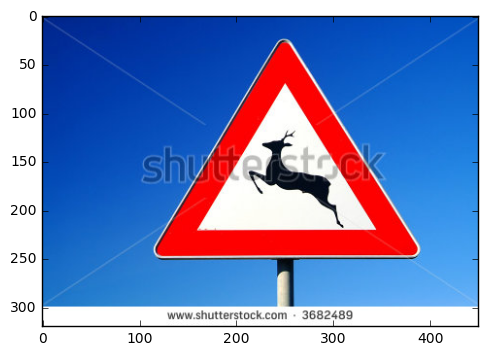

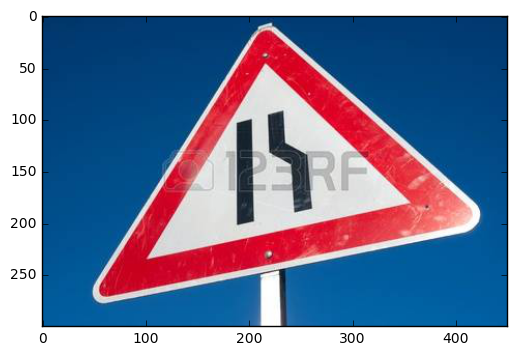

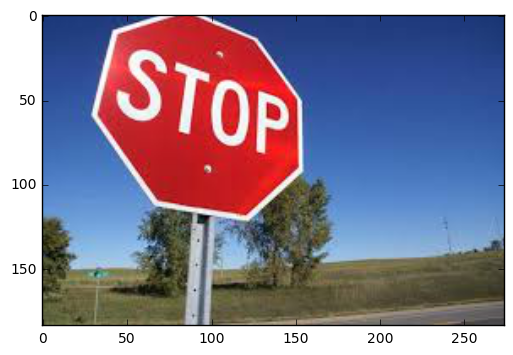

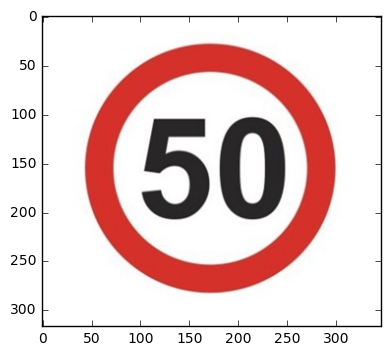

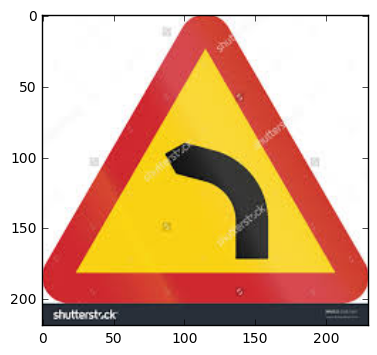

In [79]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import math
import cv2
# Visualizations will be shown in the notebook.
%matplotlib inline

extra_images_folder = "extra_test_images"
all_files = [f for f in listdir(extra_images_folder) if isfile(join(extra_images_folder, f))]
print (all_files)

extra_test_images = [mpimg.imread(extra_images_folder + "/" + file) for file in all_files]
resized_images = [cv2.resize(each_image, (32, 32)) for each_image in extra_test_images]
#Check Random Five Images
plt.imshow(np.array(extra_test_images[0]))
plt.show()
plt.imshow(np.array(extra_test_images[1]))
plt.show()
plt.imshow(np.array(extra_test_images[2]))
plt.show()
plt.imshow(np.array(extra_test_images[3]))
plt.show()
plt.imshow(np.array(extra_test_images[4]))
plt.show()

In [88]:
test_images_grayscaled = []
for each_img in resized_images:
    test_images_grayscaled.append(convert_to_grayscale(each_img))
images_test_extra = np.array(images_test_grayscaled)
labels_extra_test_images = np.array([31, 24, 14, 2, 19])
normalized_images = normalize_images(test_images_grayscaled)
normalized_images_grayscaled = np.expand_dims(normalized_images, axis=3)

In [96]:
saver.restore(sess=sess, save_path=save_path)
acc = accuracy.eval({x: normalized_images_grayscaled, y: convert_to_one_hot(labels_extra_test_images)}, session=sess)
print("Accuracy on Internet Test data Model - ", "{:.8f}".format(acc))

Accuracy on Internet Test data Model -  0.80000001


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

I got an accuracy of 80% on these random images downloaded from the internet. The accuracy is lower than that on test data but only 1 image has been wrongly classified because the sign is tilted in opposite direction to that present in training data.

In [97]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
import csv
import json
traffic_sign_classes_names = []
csv_file = open("signnames.csv", "r")
csv_reader = csv.DictReader(csv_file)
for each_row in csv_reader:
    traffic_sign_classes_names.append(each_row['SignName'])
print (traffic_sign_classes_names)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


In [98]:
softmax_predictions = tf.nn.softmax(logits)
top_five = tf.nn.top_k(softmax_predictions, k=5)
prob = top_five.values.eval({x: normalized_images_grayscaled}, session=sess)
classes = top_five.indices.eval({x: normalized_images_grayscaled}, session=sess)

print(prob)
print(classes)

[[  9.91655588e-01   5.32458350e-03   2.52620247e-03   4.90503095e-04
    1.34529978e-06]
 [  9.90993202e-01   6.81031402e-03   1.84777367e-03   3.48186120e-04
    2.96577497e-07]
 [  9.93793845e-01   5.92657877e-03   1.36010480e-04   9.98117248e-05
    3.41787381e-05]
 [  1.00000000e+00   1.55851859e-10   4.46436811e-12   8.39181494e-14
    1.76174144e-16]
 [  1.00000000e+00   5.26840473e-08   2.32428399e-12   7.54608575e-14
    3.79687872e-14]]
[[31 21 29 23 19]
 [24 18 27 26 21]
 [22 13 35 26 38]
 [ 2  5  3  7 33]
 [19 23 26  0  1]]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

**Certain** - The model is certain of ***1) Wild animals crossing with confidence of 99.16%, 2) Road narrows on the right with confidence of 99.09%, 4) Speed Limit 50 with confidence of 100%*** and of ***5) Dangerous curve to the left with confidence of 100%***. 

**Uncertain** - The model failed to correctly predict ***3) STOP sign***. It doesn't even feature in top 5. The reason may be that the stop sign displayed here is tilted in the opposite direction as compared to training images for the same sign.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.